In [1]:
pip install highlight-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from matplotlib import rcParams
from highlight_text import fig_text
import pandas as pd

from PIL import Image
import urllib
import os

In [3]:
url = "https://raw.githubusercontent.com/iqbalridalta/football-sonofcorner/main/visualization/080122-Ball%20Touches/seriea_touches_07252022.csv"

data = pd.read_csv(url, index_col = 0)

In [9]:
data.head()

,playerId,playerName,teamId,minutes,touches,teamName
0,1002039,Aaron Hickey,9857,2834,1729.0,Bologna
1,1003368,Junior Messias,8564,1429,878.0,Milan
2,1020963,Nicolo Rovella,10233,1466,1210.0,Genoa
3,1021834,Jakub Kiwior,9881,1963,974.0,Spezia
4,1027472,Wilfried Singo,9804,2626,1893.0,Torino


In [4]:
inequality_df = (
    data.groupby(["teamId", "teamName"])
    ["touches"]
    .agg(bottom_4 = lambda x: x.quantile(.4), top_10 = lambda x: x.quantile(.9))
    .reset_index()
)

inequality_df["palma_ratio"] = inequality_df["top_10"]/inequality_df["bottom_4"]

In [6]:
inequality_df.head()

,teamId,teamName,bottom_4,top_10,palma_ratio
0,6480,Salernitana,721.2,1255.2,1.740433
1,7881,Venezia,808.2,1557.8,1.927493
2,7943,Sassuolo,1378.0,2299.5,1.668723
3,8524,Atalanta,1150.6,2037.4,1.770728
4,8529,Cagliari,1041.0,1411.0,1.355427


In [7]:
# Computing the Hoover Index
def hoover_index(team_id, df):
    '''
    This function calculates the Hoover Index
    for a given team.
    '''

    data = df.copy()
    data = data[data["teamId"] == team_id]

    mean_ = data["touches"].mean()

    data["abs_diff"] = (
        abs(data["touches"] - mean_)
    )

    hoover_index = 0.5*(data["abs_diff"].sum())/data["touches"].sum()

    return hoover_index

In [8]:
# Computing the Gini Coefficient


def gini_coefficient(team_id, df):
    '''
    This function calculates the Gini Coefficient
    for a given team.
    '''

    data = df.copy()
    data = data[data["teamId"] == team_id]

    mean_ = data["touches"].mean()

    abs_differences = []
    for i in data["touches"]:
        for j in data["touches"]:
            abs_differences.append(abs(i - j))
    
    abs_diff_sum = sum(abs_differences)

    gini_coefficient = (
        abs_diff_sum/(2 * (data.shape[0]**2) * mean_)
    )

    return  gini_coefficient

In [21]:
for index, team in enumerate(inequality_df["teamId"]):
    inequality_df["hoover_index"].iloc[index] = hoover_index(team, df = data)
    #inequality_df["gini_coefficient"].iloc[index] = gini_coefficient(team, df = data)


KeyError: ignored

In [22]:
for index, team in enumerate(inequality_df["teamId"]):
    inequality_df["hoover_index"].iloc[index] = hoover_index(team, df = data)
    inequality_df["gini_coefficient"].iloc[index] = gini_coefficient(team, df = data)


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [23]:
inequality_df.head()

,teamId,teamName,bottom_4,top_10,palma_ratio,hoover_index,gini_coefficient
0,6480,Salernitana,721.2,1255.2,1.740433,0.112439,0.153817
1,7881,Venezia,808.2,1557.8,1.927493,0.156074,0.203456
2,7943,Sassuolo,1378.0,2299.5,1.668723,0.153096,0.222401
3,8524,Atalanta,1150.6,2037.4,1.770728,0.133817,0.164459
4,8529,Cagliari,1041.0,1411.0,1.355427,0.114759,0.158438


In [24]:
hoover_index(team, df = data)

0.17605221097496004

In [19]:
#---------------------------------
# Making the visual
# --------------------------------

def plot_inequality(ax, fig, metric, df):
    '''
    This function helps us save a bit of code to plot
    the different inequality metrics of our visual
    '''

    data = df.copy()
    data = (
        data
        .sort_values(by = metric, ascending = False)
        .reset_index(drop = True)
    )
    plt.rcParams['hatch.linewidth'] = 0.45
    width = 0.5
    ax.bar(
        data.index, 
        data[metric], 
        ec = "#000000", 
        fc = "#74959A", 
        alpha = 0.75,
        hatch = "//////////", 
        zorder = 3, 
        width = width
    )

    for index, value in enumerate(data[metric]):
        if metric == "palma_ratio":
            format_str = f"{value:.1f}x"
        elif metric == "gini_coefficient":
            format_str = f"{value:.2f}"
        else:
            format_str = f"{value:.1%}"
        text_ = ax.annotate(
            xy = (index, value),
            xytext = (1, -15),
            s = format_str,
            textcoords = "offset points",
            rotation = 90,
            ha = "center",
            va = "center",
            color = "black",
            size = 7
        )
        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.75, foreground="white"), 
            path_effects.Normal()]
        )

    # --- Axes transformations

    ax.set_xlim(-.55, 19.55)
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)

    xticks_ = ax.xaxis.set_ticks(
        ticks = data.index,
        #labels = []
    )


    ax.tick_params(labelsize = 8)

    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform

    # Native data to normalized data coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

    fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
    for index, teamId in enumerate(data["teamId"]):
        ax_coords = DC_to_NFC([index - 0.35, -ax.get_ylim()[1]*.175])
        logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = "W")
        club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{teamId:.0f}.png")).convert("LA")
        logo_ax.imshow(club_icon)
        logo_ax.axis("off")
    
    ax.tick_params(labelsize = 10)

    return ax



AttributeError: ignored

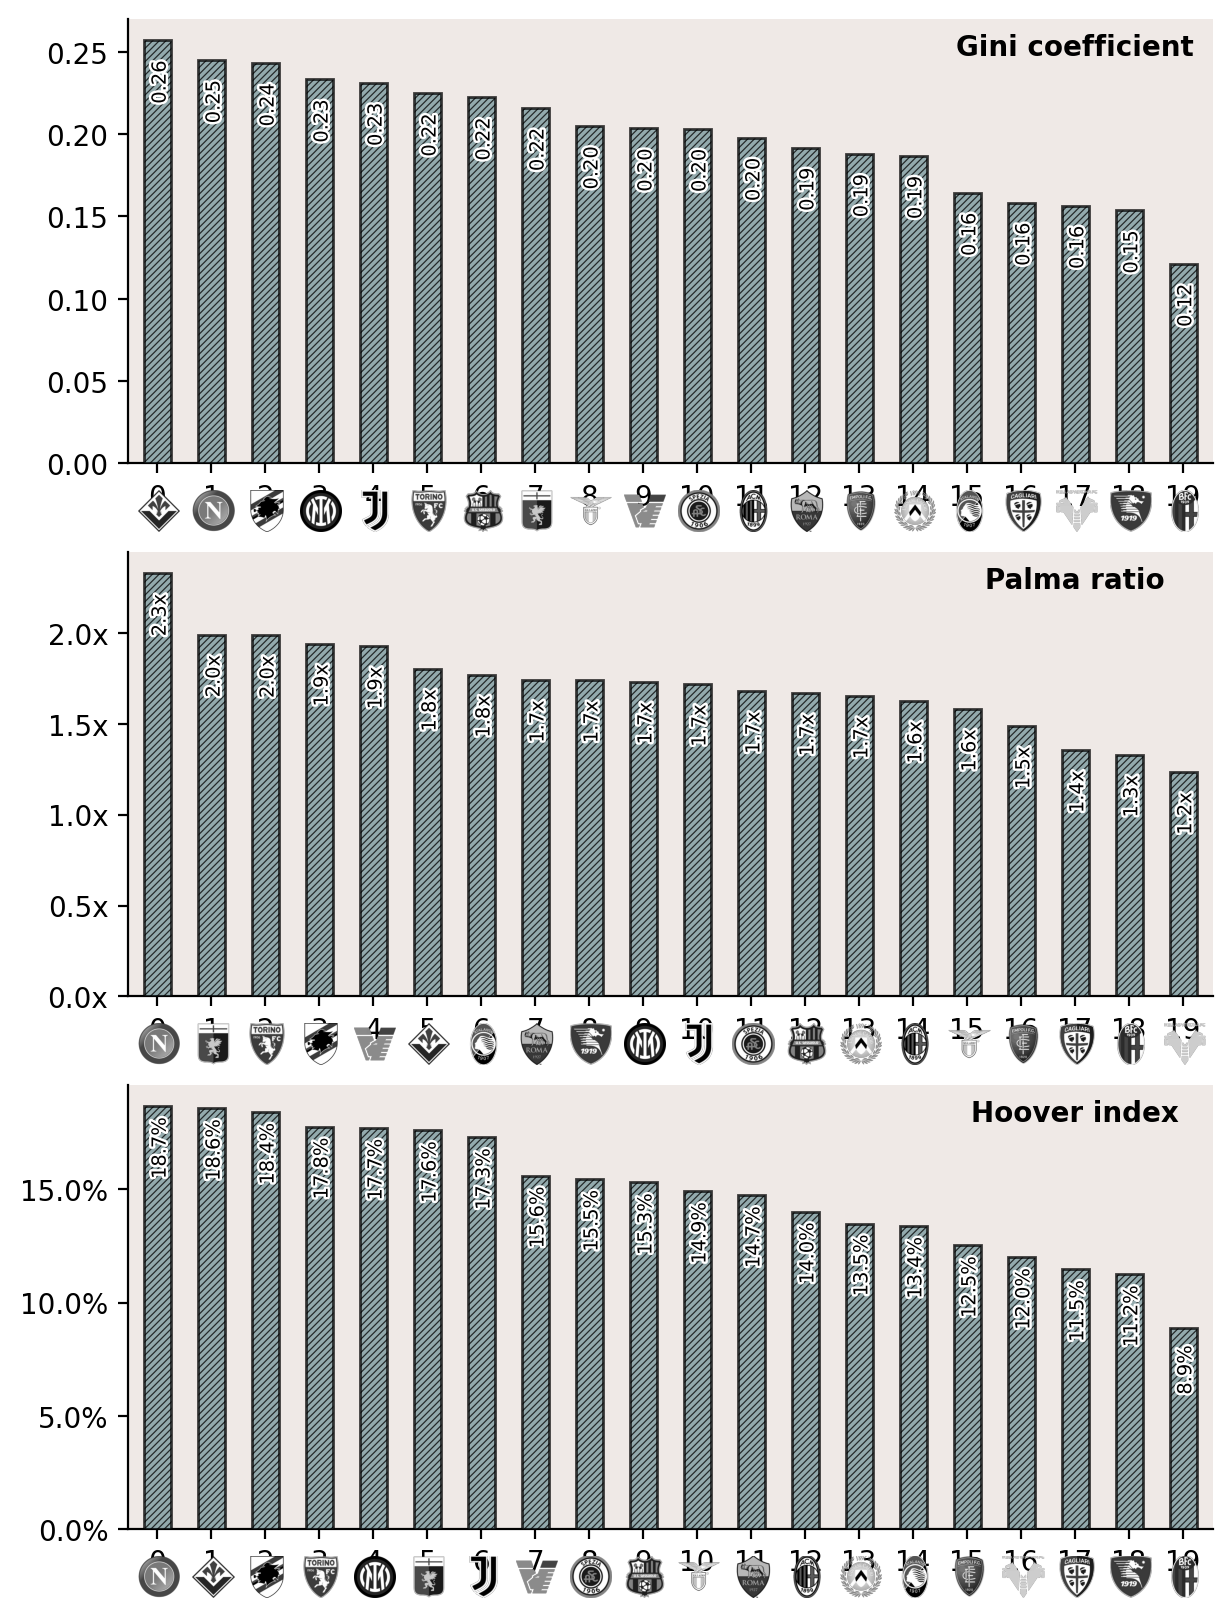

In [25]:
# The final plot

fig = plt.figure(figsize=(7, 10), dpi = 200)
ax_gini = fig.add_subplot(311, facecolor = "#EFE9E6")
ax_palma = fig.add_subplot(312, facecolor = "#EFE9E6")
ax_hoover = fig.add_subplot(313, facecolor = "#EFE9E6")


plot_inequality(ax_gini, fig, "gini_coefficient", inequality_df)
ax_gini.annotate(
    xy = (17, ax_gini.get_ylim()[1]),
    xytext = (0, -10),
    textcoords = "offset points",
    s = "Gini coefficient",
    weight = "bold",
    ha = "center",
    va = "center"
)
plot_inequality(ax_palma, fig, "palma_ratio", inequality_df)
ax_palma.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}x"))
ax_palma.annotate(
    xy = (17, ax_palma.get_ylim()[1]),
    xytext = (0, -10),
    textcoords = "offset points",
    s = "Palma ratio",
    weight = "bold",
    ha = "center",
    va = "center"
)
plot_inequality(ax_hoover, fig, "hoover_index", inequality_df)
ax_hoover.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1%}"))
ax_hoover.annotate(
    xy = (17, ax_hoover.get_ylim()[1]),
    xytext = (0, -10),
    textcoords = "offset points",
    s = "Hoover index",
    weight = "bold",
    ha = "center",
    va = "center"
)

plt.subplots_adjust(hspace=0.2)


fig_text(
    x = 0.11, y = 1.035, 
    s = "Which Serie A teams have the most equal\nspread of ball touches?",
    va = "bottom", ha = "left",
    fontsize = 15, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.11, y = .895, 
    s = "Inequality ratios on Serie A teams ball touches | Season 2021/2022 | Viz by @sonofacorner\nPlayers with +1,000 minutes. Ordered from most unequal to least equal spread of touches.\n\n<- Gini> is an index that measures inequality within a population, it takes values from 0\n (complete equality) to 1 (complete inequality).\n<- Palma> is a ratio that can be interpreted as the top 10% of players with the most touches have \nX times more touches than the bottom 40%.\n<- Hoover> measures the amount of touches that would need to be redistributed for all players to\nhave the same number of touches.",
    highlight_textprops=[{"weight": "bold", "color": "black"}, {"weight": "bold", "color": "black"}, {"weight": "bold", "color": "black"}],
	va = "bottom", ha = "left",
	fontsize = 8, color = "#4E616C", font = "Karla"
)


plt.savefig(
	"figures/07252022_seriea_touches.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/07252022_seriea_touches_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)